# Lab 4 - Training Transformer Models for Text Classification

This notebook covers the complete pipeline for training a transformer model on an emotion classification task: dataset loading, tokenization, feature extraction, and model training.

## 1. Dataset Loading


In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
print(f"Training samples: {len(train_ds)}")
print(f"First sample: {train_ds[0]}")
print(f"Columns: {train_ds.column_names}")
print(f"Features: {train_ds.features}")


Training samples: 16000
First sample: {'text': 'i didnt feel humiliated', 'label': 0}
Columns: ['text', 'label']
Features: {'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


## 2. Data Exploration


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

emotions.set_format(type="pandas")
df = emotions["train"][:]

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


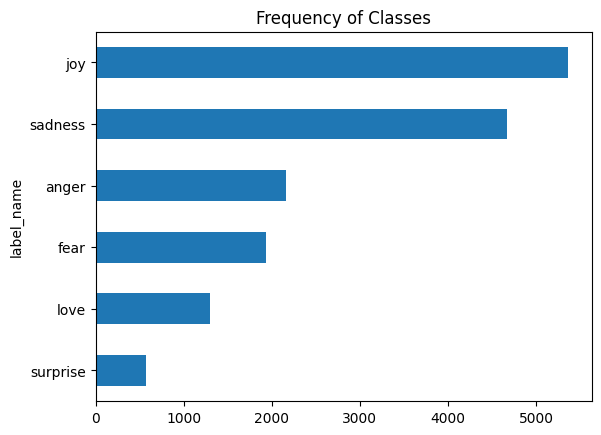

In [6]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()


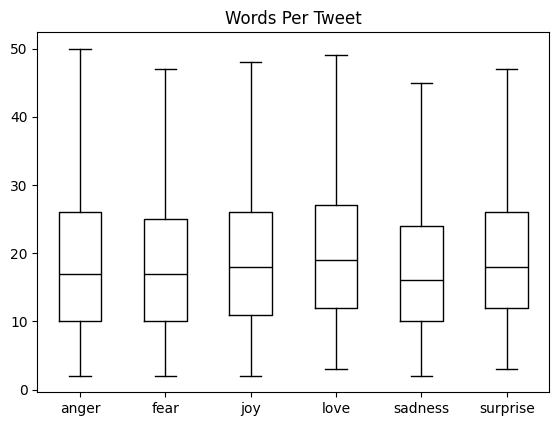

In [7]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

emotions.reset_format()


## 3. Tokenization

Using DistilBERT tokenizer to convert text to token IDs:


In [8]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(f"Encoded: {encoded_text}")

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(f"Tokens: {tokens}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Max length: {tokenizer.model_max_length}")


Encoded: {'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
Vocab size: 30522
Max length: 512


In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)


Map: 100%|██████████| 2000/2000 [00:00<00:00, 14064.44 examples/s]

['text', 'label', 'input_ids', 'attention_mask']


## 4. Feature Extraction with Transformers

Using the pre-trained model to extract hidden states as features:


In [10]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

def extract_hidden_states(batch):
    inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=8)


Map: 100%|██████████| 2000/2000 [01:45<00:00, 18.91 examples/s]


## 5. Training a Classifier

Using the extracted features to train a logistic regression classifier:


In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=emotions["train"].features["label"].names))


              precision    recall  f1-score   support

     sadness       0.65      0.71      0.68       550
         joy       0.71      0.80      0.75       704
        love       0.49      0.30      0.37       178
       anger       0.51      0.44      0.47       275
        fear       0.55      0.56      0.55       212
    surprise       0.54      0.27      0.36        81

    accuracy                           0.63      2000
   macro avg       0.57      0.51      0.53      2000
weighted avg       0.62      0.63      0.62      2000



## 6. Fine-tuning with Trainer API

Training the full transformer model with Hugging Face Trainer:


In [12]:
%pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
preds_output = trainer.predict(emotions_encoded["test"])
print(f"Test metrics: {preds_output.metrics}")
